In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ECE:760/hw\ 2

/content/drive/MyDrive/ECE:760/hw 2


In [146]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [32]:
#Helper function to load data
def load_data(filename_with_path):
  '''
    Load input and label data from a file.

    Args:
        filename_with_path (str): The full path and name of the data file.

    Returns:
        tuple: Two numpy arrays containing the input features (X) and labels (Y).
  '''
  
  df=pd.read_csv(filename_with_path,delimiter=' ',header=None).to_numpy()
  X=df[:,:2] #All data files in this assignment have two features
  Y=df[:,2]

  return X,Y

In [152]:
#The Decision Tree Classifier class along with a class for the node

class Node:
    def __init__(self, left=None, right=None, feature=None, threshold=None, label=None):
      self.left=left
      self.right=right
      self.feature=feature
      self.threshold=threshold

      #If node is a leaf, then self.label would be 0 or 1 depending on the classifier result
      self.label=label


    def is_node_a_leaf(self):
      if self.label is not None:
        return True
      return False

class DecisionTreeClassifier:
    def __init__(self):
      self.root=None

    def train_tree(self,X,Y):
      self.root=self._make_tree(X,Y)

    def _make_tree(self,X,Y):
      #Find indices of Y that are having label 1 and 0 respectively
      pos_idx, neg_idx= self._get_label_indices(Y)
      #Check for stopping criteria
      """
      The three stopping criteria given in the question are as follows:
      -> the node is empty, or
      –> all splits have zero gain ratio (if the entropy of the split is non-zero), or
      –> the entropy of any candidates split is zero
      """
      if X.shape[0]==0 or len(pos_idx)==0 or len(neg_idx)==0:
        #Create a leaf node with label based on which is greater (len(pos_idx) or len(neg_idx))
        if len(pos_idx)>=len(neg_idx):
          label=1
        else:
          label=0

        return Node(label=label)

      
      #Else, grow tree further
      best_feature, best_thr = self._get_best_split(X,Y)
      
      # create child nodes
      left_branch_idxs, right_branch_idxs = self._split_feature_by_threshold(X[:, best_feature], best_thr)
      left = self._make_tree(X[left_branch_idxs, :], Y[left_branch_idxs])
      right = self._make_tree(X[right_branch_idxs, :], Y[right_branch_idxs])
      return Node(left, right,best_feature, best_thr)

    def _get_label_indices(self,Y):
      pos_idx=np.where(Y==1)[0] #np.where returns the indices in a tuple, so taking the first element
      neg_idx=np.where(Y==0)[0]

      return pos_idx, neg_idx
    

    def _get_best_split(self,X,Y):
      best_gain = -np.inf
      split_idx, split_thr = None, None

      for feat_idx in [0,1]:
        feature = X[:, feat_idx]
        thrs = np.unique(feature)

        for thr in thrs:
            # calculate the information gain
            gain = self._get_information_gain_ratio(Y,feature, thr)

            if gain > best_gain:
                best_gain = gain
                split_idx = feat_idx
                split_thr = thr

      return split_idx, split_thr


    def _get_information_gain_ratio(self, Y, feature, threshold):
      # initial entropy
      initial_entropy = self._calculate_entropy(Y)

      # create children
      left_branch_idxs, right_branch_idxs = self._split_feature_by_threshold(feature, threshold)

      if len(left_branch_idxs) == 0 or len(right_branch_idxs) == 0:
          return 0
      
      # calculate the weighted avg. entropy of children
      n_l, n_r = len(left_branch_idxs), len(right_branch_idxs)
      e_l, e_r = self._calculate_entropy(Y[left_branch_idxs]), self._calculate_entropy(Y[right_branch_idxs])
      split_entropy = ((n_l) * e_l + (n_r) * e_r)/len(Y)

      # calculate the IG
      information_gain = initial_entropy - split_entropy

      #calculate the intrinsic information
      left_part=n_l/len(Y)*math.log2(n_l/len(Y))
      right_part=n_r/len(Y)*math.log2(n_r/len(Y))
      intrinisc_info=-(left_part+right_part)

      return information_gain/intrinisc_info
    
    def _calculate_entropy(self,Y):
      """
      Takes in the labels and returns the entropy.
      Args:
        Y (array): A 1D array of labels
      
      Returns: 
        Float denoting the entropy of the label array
      """
      prob = np.unique(Y,return_counts=True)[1]/len(Y)
      entropy_array=[k*np.log2(k) for k in prob]

      return -np.sum(entropy_array)

    def _split_feature_by_threshold(self,feature,thr):
      """
      Splits a feature array into two parts based on a threshold value.

      Args:
          feature (array): A 1D array of feature values.
          thr (float): The threshold value for splitting the feature array.

      Returns:
          tuple containing two arrays denoting left branch and right branch split indices
      """

      left_side_idxs=np.where(feature>=thr)[0]
      right_side_idxs=np.where(feature<thr)[0]

      return left_side_idxs, right_side_idxs

    def print_tree(self):
      DecisionTreeClassifier._depth_traversal_preorder(self.root)

    @staticmethod
    def _depth_traversal_preorder(node):
      if node:
        if node.is_node_a_leaf():
            print(f"Leaf Node---Label:{node.label}")
        else:
          print(f"Feature:{node.feature}, Threshold:{node.threshold}")

          
  
          # Then print the left-subtree
          if node.left:
            DecisionTreeClassifier._depth_traversal_preorder(node.left)
          
          # Then print the right subtree
          if node.right:
            DecisionTreeClassifier._depth_traversal_preorder(node.right)

    def make_prediction(self, X):
        return np.array([DecisionTreeClassifier._traverse_for_prediction(x, self.root) for x in X])

    @staticmethod
    def _traverse_for_prediction(x, node):
        if node.is_node_a_leaf():
            return node.label

        if x[node.feature] >= node.threshold:
            return DecisionTreeClassifier._traverse_for_prediction(x, node.left)
        return DecisionTreeClassifier._traverse_for_prediction(x, node.right)

    def count_nodes(self):
      return DecisionTreeClassifier._get_num_nodes(self.root)

    @staticmethod
    def _get_num_nodes(node):
      if node is None:
        return 0
      return 1 + DecisionTreeClassifier._get_num_nodes(node.left) + DecisionTreeClassifier._get_num_nodes(node.right)


#####Part-2

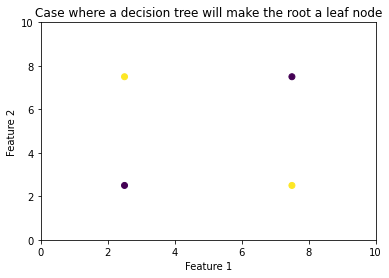

In [30]:

import matplotlib.pyplot as plt
import numpy as np

# Training data
X = np.array([[2.5,2.5],
              [2.5,7.5],
              [7.5, 2.5],
              [7.5, 7.5]])

y = np.array([0, 1, 1, 0])

# Plot the training data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlim((0,10))
plt.ylim((0,10))
plt.title('Case where a decision tree will make the root a leaf node')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#####Part-3 

In [36]:

X,Y=load_data('/content/drive/MyDrive/ECE:760/hw 2/data/Druns.txt')

In [77]:
def calculate_entropy(Y):
      """
      Takes in the labels and returns the entropy.
      Args:
        Y (array): A 1D array of labels
      
      Returns: 
        Float denoting the entropy of the label array
      """
      prob = np.unique(Y,return_counts=True)[1]/len(Y)
      entropy_array=[k*np.log2(k) for k in prob]

      return -np.sum(entropy_array)

def get_information_gain_ratio(Y, feature, threshold):
      # initial entropy
      initial_entropy = calculate_entropy(Y)
      # create children
      left_branch_idxs, right_branch_idxs = split_feature_by_threshold(feature, threshold)

      if len(left_branch_idxs) == 0 or len(right_branch_idxs) == 0:
          return 0
      
      # calculate the weighted avg. entropy of children
      n_l, n_r = len(left_branch_idxs), len(right_branch_idxs)
      e_l, e_r = calculate_entropy(Y[left_branch_idxs]), calculate_entropy(Y[right_branch_idxs])
      
      split_entropy = ((n_l) * e_l + (n_r) * e_r)/len(Y)


      # calculate the IG
      information_gain = initial_entropy - split_entropy
      #calculate the intrinsic information
      left_part=n_l/len(Y)*math.log2(n_l/len(Y))
      right_part=n_r/len(Y)*math.log2(n_r/len(Y))
      intrinisc_info=-(left_part+right_part)

      return information_gain/intrinisc_info

def split_feature_by_threshold(feature,thr):
      """
      Splits a feature array into two parts based on a threshold value.

      Args:
          feature (array): A 1D array of feature values.
          thr (float): The threshold value for splitting the feature array.

      Returns:
          tuple containing two arrays denoting left branch and right branch split indices
      """

      left_side_idxs=np.where(feature>=thr)[0]
      right_side_idxs=np.where(feature<thr)[0]

      return left_side_idxs, right_side_idxs



In [78]:
for feat_idx in [0,1]:
        feature = X[:, feat_idx]
        thrs = np.unique(feature)

        for thr in thrs:
          print(f"feature index: {feat_idx}, Threshold: {thr}, Information Gain Ratio: {get_information_gain_ratio(Y,feature,thr)}")

feature index: 0, Threshold: 0.0, Information Gain Ratio: 0
feature index: 0, Threshold: 0.1, Information Gain Ratio: 0.10051807676021828
feature index: 1, Threshold: -2.0, Information Gain Ratio: 0
feature index: 1, Threshold: -1.0, Information Gain Ratio: 0.10051807676021828
feature index: 1, Threshold: 0.0, Information Gain Ratio: 0.055953759631263845
feature index: 1, Threshold: 1.0, Information Gain Ratio: 0.005780042205152189
feature index: 1, Threshold: 2.0, Information Gain Ratio: 0.001144349517276632
feature index: 1, Threshold: 3.0, Information Gain Ratio: 0.016411136842102134
feature index: 1, Threshold: 4.0, Information Gain Ratio: 0.049749064181778435
feature index: 1, Threshold: 5.0, Information Gain Ratio: 0.11124029586339801
feature index: 1, Threshold: 6.0, Information Gain Ratio: 0.23609960614360798
feature index: 1, Threshold: 7.0, Information Gain Ratio: 0.055953759631263845
feature index: 1, Threshold: 8.0, Information Gain Ratio: 0.4301569161309807


####Part-4


In [86]:

X,Y=load_data('/content/drive/MyDrive/ECE:760/hw 2/data/D3leaves.txt')

In [126]:
tree=DecisionTreeClassifier()

In [127]:
tree.train_tree(X,Y)

In [128]:
tree.print_tree()

Feature:0, Threshold:10
Leaf Node---Label:1
Feature:1, Threshold:3
Leaf Node---Label:1
Leaf Node---Label:0


####Part-5

In [130]:
X1,Y1=load_data('/content/drive/MyDrive/ECE:760/hw 2/data/D1.txt')
tree1=DecisionTreeClassifier()
tree1.train_tree(X1,Y1)
tree1.print_tree()

Feature:1, Threshold:0.201829
Leaf Node---Label:1
Leaf Node---Label:0


In [131]:
X2,Y2=load_data('/content/drive/MyDrive/ECE:760/hw 2/data/D2.txt')
tree2=DecisionTreeClassifier()
tree2.train_tree(X2,Y2)
tree2.print_tree()

Feature:0, Threshold:0.533076
Feature:1, Threshold:0.228007
Feature:1, Threshold:0.424906
Leaf Node---Label:1
Feature:0, Threshold:0.708127
Leaf Node---Label:1
Feature:1, Threshold:0.32625
Feature:0, Threshold:0.595471
Feature:0, Threshold:0.646007
Leaf Node---Label:1
Feature:1, Threshold:0.403494
Leaf Node---Label:1
Leaf Node---Label:0
Leaf Node---Label:0
Leaf Node---Label:0
Feature:0, Threshold:0.887224
Feature:1, Threshold:0.037708
Feature:1, Threshold:0.082895
Leaf Node---Label:1
Feature:0, Threshold:0.960783
Leaf Node---Label:1
Leaf Node---Label:0
Leaf Node---Label:0
Feature:0, Threshold:0.850316
Feature:1, Threshold:0.169053
Leaf Node---Label:1
Leaf Node---Label:0
Leaf Node---Label:0
Feature:1, Threshold:0.88635
Feature:0, Threshold:0.041245
Feature:0, Threshold:0.104043
Leaf Node---Label:1
Feature:0, Threshold:0.07642
Leaf Node---Label:0
Leaf Node---Label:1
Leaf Node---Label:0
Feature:1, Threshold:0.691474
Feature:0, Threshold:0.254049
Leaf Node---Label:1
Feature:0, Threshold:0.

####Part-6

Text(0.5, 1.0, 'The scatter plot of D1.txt')

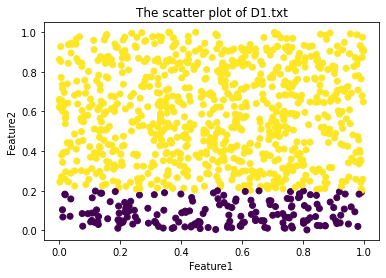

In [133]:
#Scatter-Plot of D1.txt
plt.scatter(X1[:,0],X1[:,1],c=Y1)
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.title("The scatter plot of D1.txt")

Text(0.5, 1.0, 'The scatter plot of D2.txt')

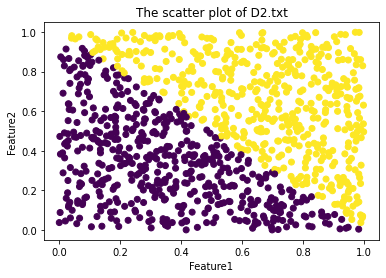

In [134]:
#Scatter-Plot of D2.txt
plt.scatter(X2[:,0],X2[:,1],c=Y2)
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.title("The scatter plot of D2.txt")

Text(0.5, 1.0, 'The scatter plot of D1.txt with decision boundary')

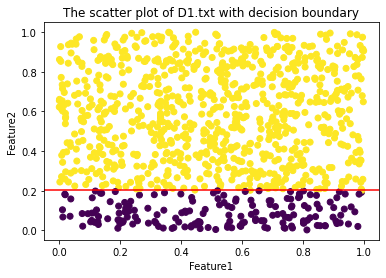

In [141]:
#Scatter-Plot of D1.txt with the horizontal line
plt.scatter(X1[:,0],X1[:,1],c=Y1)
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.axhline(y=0.201829,color='red')
plt.title("The scatter plot of D1.txt with decision boundary")

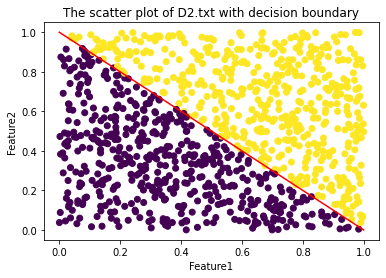

In [140]:
#Scatter-Plot of D2.txt
plt.scatter(X2[:,0],X2[:,1],c=Y2)
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.title("The scatter plot of D2.txt with decision boundary")
x_vals = np.linspace(X2.min(), X2.max(), 100)
y_vals = -x_vals + 1
plt.plot(x_vals, y_vals, color='red')

####Part-7

In [148]:
X,Y=load_data('/content/drive/MyDrive/ECE:760/hw 2/data/Dbig.txt')
#Generating splits of data (D32, D128, D512, D2048, D8192)
X_8192,X_test,Y_8192,Y_test=train_test_split(X,Y,train_size=8192,stratify=Y)
X_32,Y_32=X_8192[:32,:],Y_8192[:32]
X_128,Y_128=X_8192[:128,:],Y_8192[:128]
X_512,Y_512=X_8192[:512,:],Y_8192[:512]
X_2048,Y_2048=X_8192[:2048,:],Y_8192[:2048]

In [153]:
#The task here is to train a DT model on each of these splits 
#and test them on X_test, Y_test to see if the test performance eventually improves

#Training and testing model on each of the splits and storing the performance in a dictionary
X_splits={"32":X_32,
          "128":X_128,
          "512":X_512,
          "2048":X_2048,
          "8192":X_8192
}
Y_splits={"32":Y_32,
          "128":Y_128,
          "512":Y_512,
          "2048":Y_2048,
          "8192":Y_8192
}

errors={}
num_nodes={}

for size in X_splits:
  tree=DecisionTreeClassifier()
  tree.train_tree(X_splits[size],Y_splits[size])
  Y_pred=tree.make_prediction(X_test)
  errors[size]=1-accuracy_score(Y_test,Y_pred)
  num_nodes[size]=tree.count_nodes()

In [154]:
errors

{'32': 0.09236725663716816,
 '128': 0.06028761061946908,
 '512': 0.044800884955752185,
 '2048': 0.031526548672566324,
 '8192': 0.01382743362831862}

In [155]:
num_nodes

{'32': 9, '128': 31, '512': 51, '2048': 155, '8192': 283}

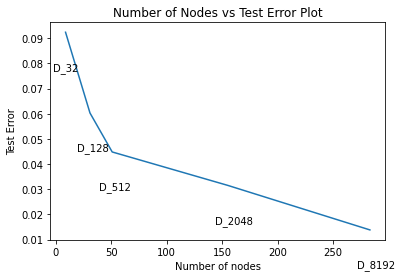

In [156]:
#plotting the graph n vs error
plt.title('Number of Nodes vs Test Error Plot')
plt.xlabel('Number of nodes')
plt.ylabel('Test Error')

node_list=[num_nodes[i] for i in num_nodes]
error_list=[errors[i] for i in errors]
plt.plot(node_list,error_list)

for i, size in enumerate(num_nodes):
  plt.annotate("D_"+size,(node_list[i],error_list[i]),xytext=(node_list[i]-11.5,error_list[i]-0.015))

plt.savefig('/content/drive/MyDrive/ECE:760/hw 2/out_figs/q2_7_errorvsnode.png')

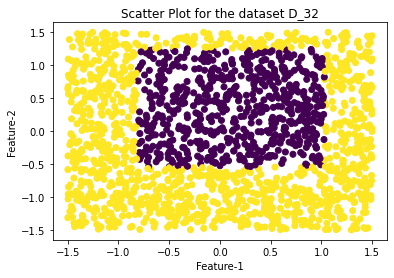

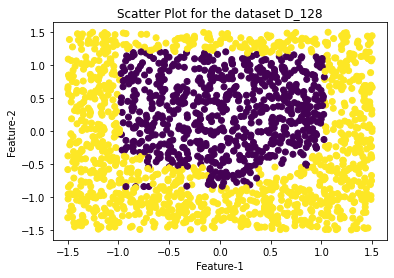

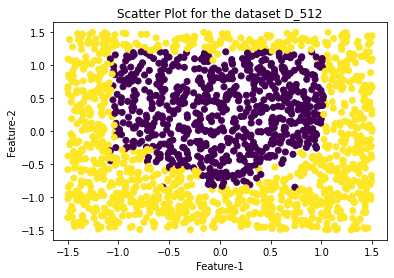

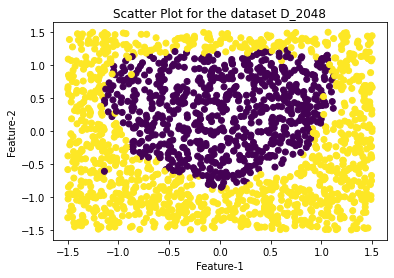

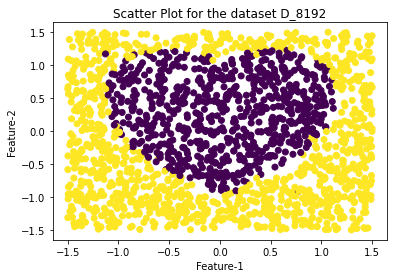

In [160]:
#Scatter-Plots 
for size in X_splits:
  tree=DecisionTreeClassifier()
  tree.train_tree(X_splits[size],Y_splits[size])
  Y_pred=tree.make_prediction(X_test)

  plt.xlabel('Feature-1')
  plt.ylabel('Feature-2')
  plt.title(f'Scatter Plot for the dataset D_{size}')
  plt.scatter(X_test[:,0],X_test[:,1],c=Y_pred)
  plt.show()